### Attempt to construct a bayes probability based trigger for the SD

recall **P(signal | bins) = P(bins | signal) * P(signal) / P(bins)**

Let's calculate **P(bins)** first, from random traces

In [5]:
from Binaries import *

AllBackgroundEvents = EventGenerator(["19_19.5"], real_background = True, prior = 0, force_inject = 0, split = 1, window_step = 1, window_length = 360)

# increase number of background traces
AllBackgroundEvents.files = np.zeros(int(1e6))


[INFO] -- LOADING NURIA: randoms0435.csv                    


In [8]:
bin_values = np.array([np.zeros(5000) for _ in range(3)])

start_time = perf_counter_ns()

for i, background_trace in enumerate(AllBackgroundEvents):

    progress_bar(i, int(1e6), start_time)

    this_bins, bin_edges = np.histogram(background_trace[0].Baseline, bins = np.linspace(-50, 5000, 5001))
    bin_values += this_bins

    raise StopIteration

StopIteration: 

Let's clip the max value to 2^11 = 2048 ADC counts <=> 9.517 VEM

(as seen below, that's not even needed, max is already ~20 ADC)

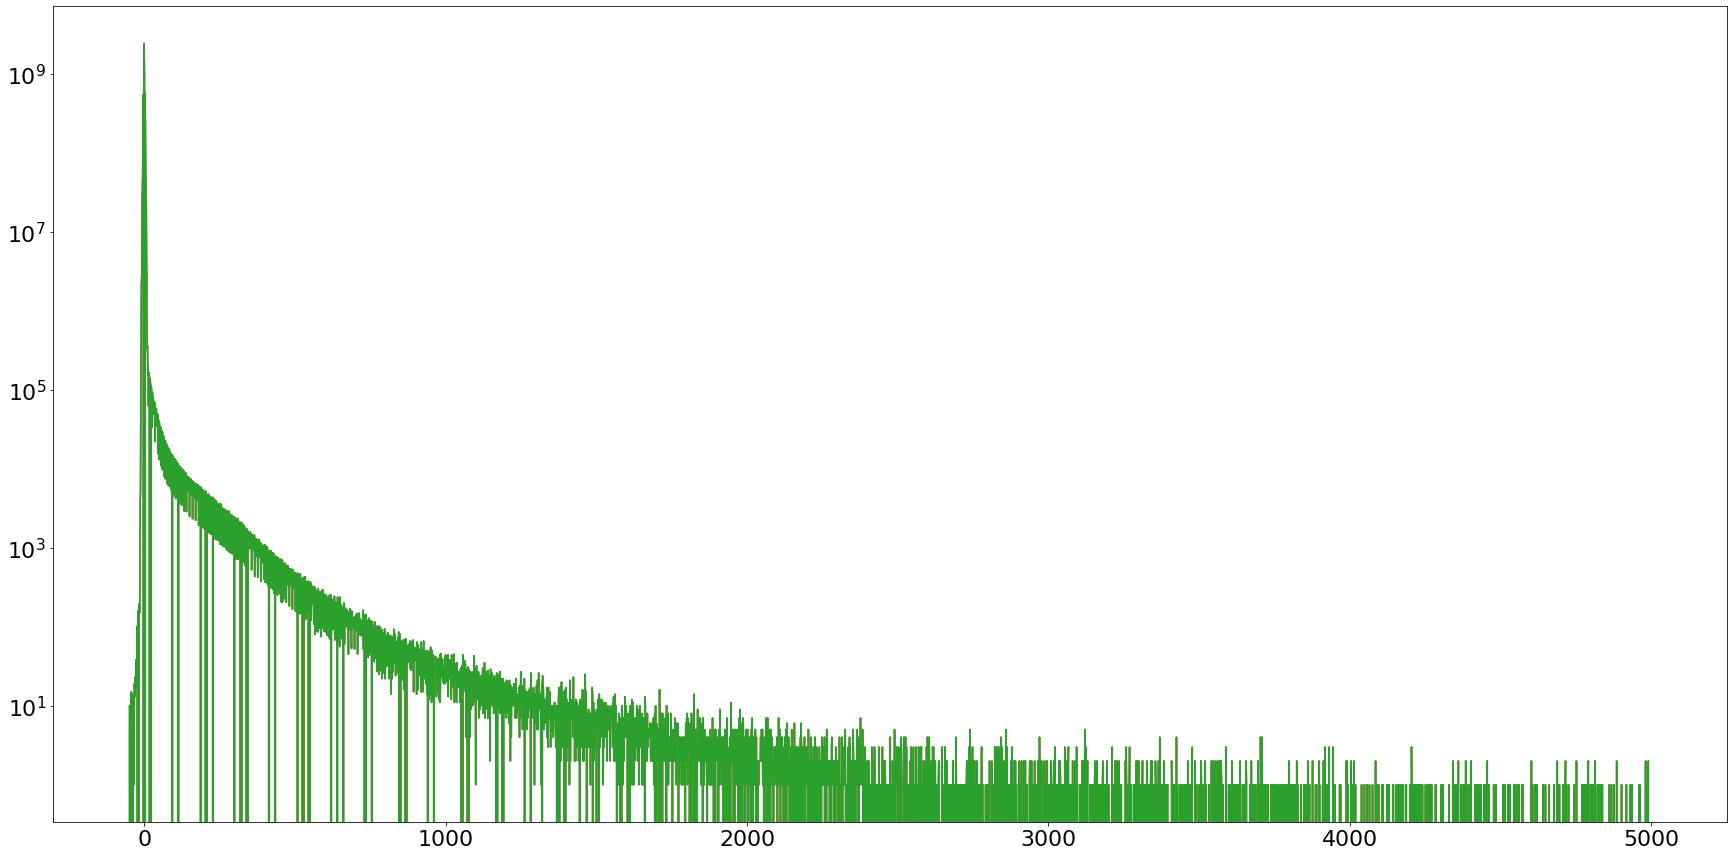

In [11]:
import numpy as np
import matplotlib.pyplot as plt



plt.yscale("log")
plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), bin_values_imported[0])
plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), bin_values_imported[1])
plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), bin_values_imported[2])

/tmp/ipykernel_2926423/25665922.py:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), (signal/background)[0])
/tmp/ipykernel_2926423/25665922.py:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), (signal/background)[0])
/tmp/ipykernel_2926423/25665922.py:9: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), (signal/background)[1])
/tmp/ipykernel_2926423/25665922.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), (signal/background)[1])
/tmp/ipykernel_2926423/25665922.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), (signal/background)[2])
/tmp/ipykernel_2926423/25665922.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]),

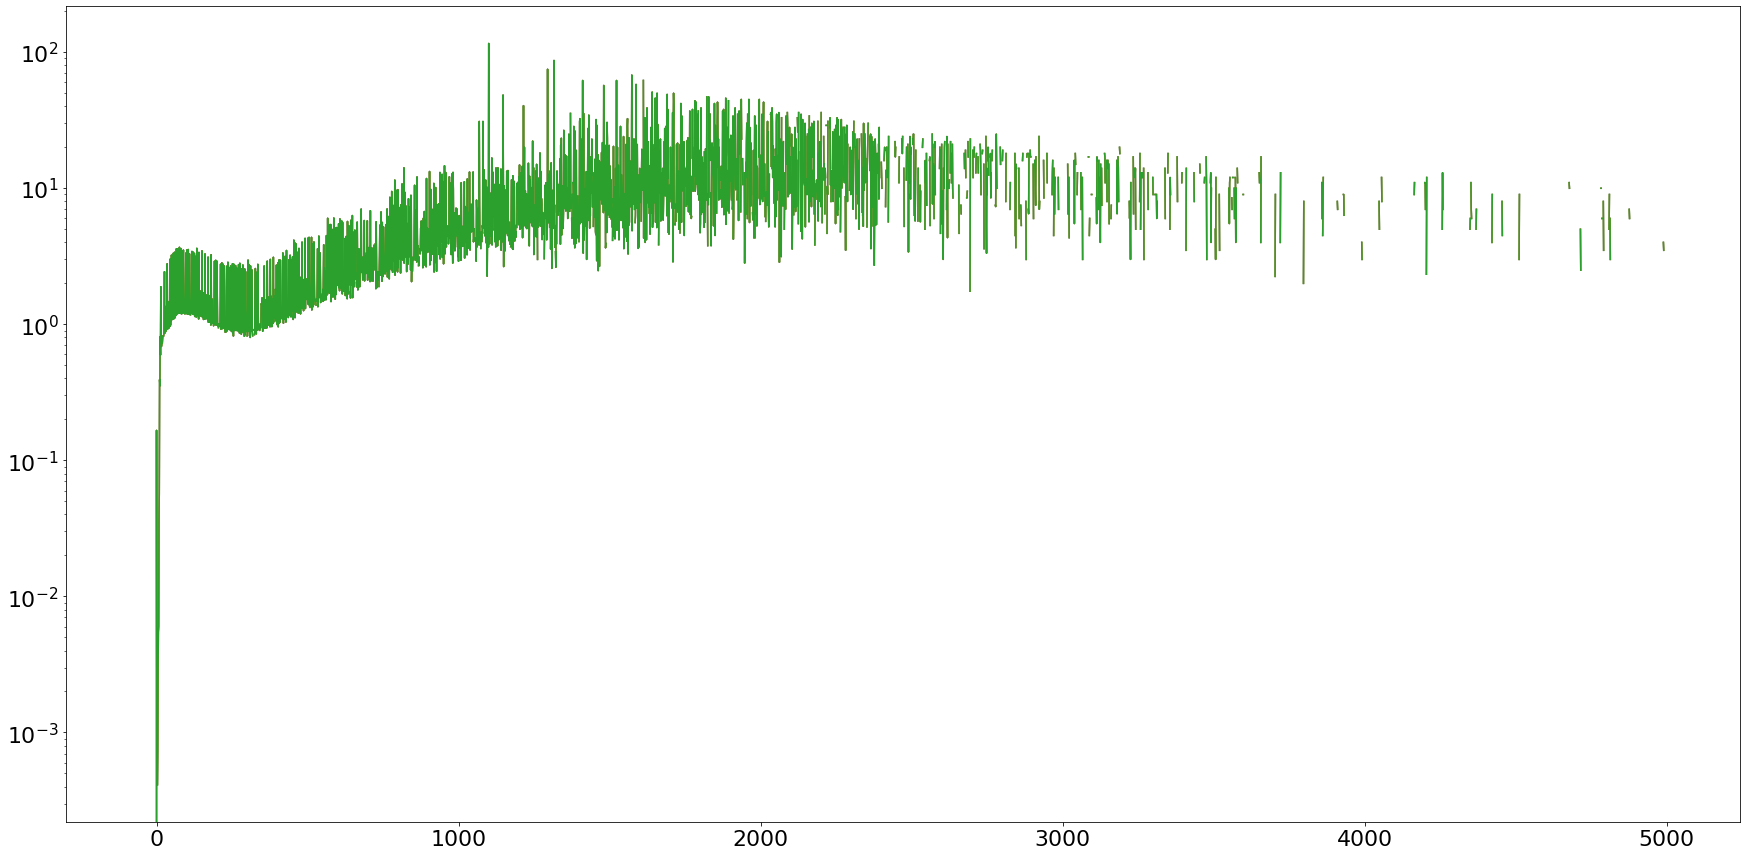

In [3]:
from Binaries import *

background = np.loadtxt("/cr/data01/filip/models/NaiveBayesClassifier/data/background_bins.csv")
signal = np.loadtxt("/cr/data01/filip/models/NaiveBayesClassifier/data/signal_bins.csv")
bin_edges = np.loadtxt("/cr/data01/filip/models/NaiveBayesClassifier/data/binning.csv")

plt.yscale("log")
plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), (signal/background)[0])
plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), (signal/background)[1])
plt.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), (signal/background)[2])

0.9999999999999999


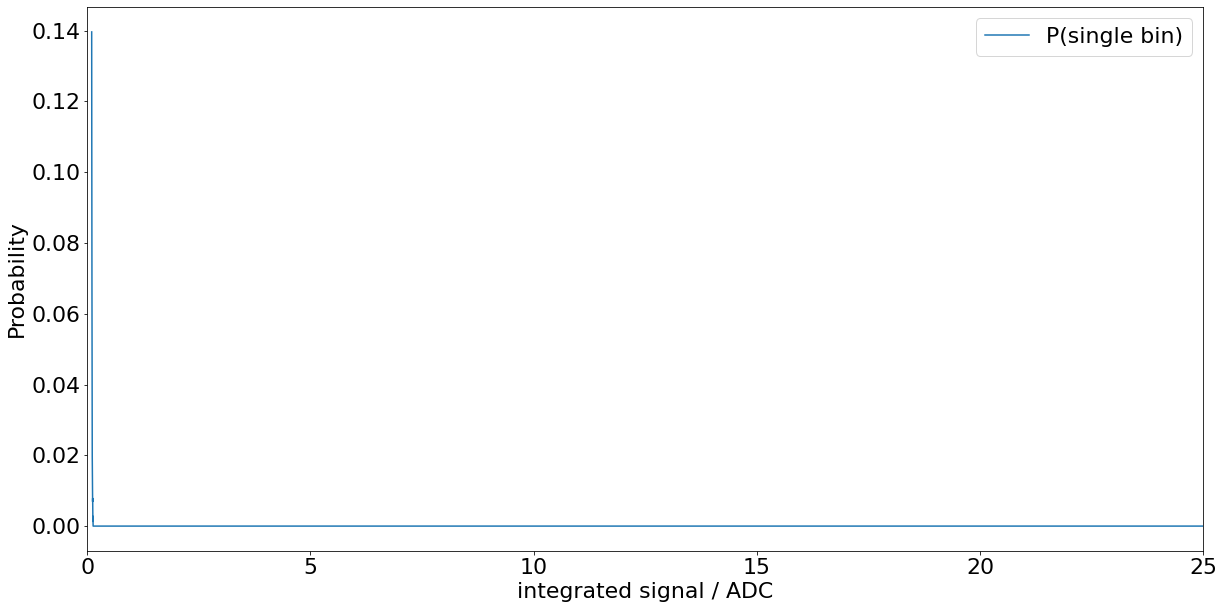

In [5]:
plt.plot(bin_centers, all_bin_pdf, label = "P(single bin)")
print(all_bin_pdf.sum())

plt.xlim(0, 25)
plt.ylabel("Probability")
plt.xlabel("integrated signal / ADC")
plt.legend()

Onto calculating P( bins | signal )

In [6]:
AllSignalEvents = EventGenerator("all", real_background = True, prior = 1, force_inject = 0, split = 1, step = 1)

bin_distributions_signal = [[] for i in range(AllSignalEvents.window_length)]

for batch in range(AllSignalEvents.__len__()):

    print(f"Processing batch {batch}: {100 * (batch/AllSignalEvents.__len__()):.2f}%", end = "\r")

    traces, _ = AllSignalEvents.__getitem__(batch, full_trace = True)

    for trace in traces:

        if not trace.has_signal: continue

        for bin in range(0, AllSignalEvents.window_length):
            bin_distributions_signal[bin].append(
                np.mean(trace.Baseline[:,0 + bin : AllSignalEvents.length - AllSignalEvents.window_length + bin]
                + trace.Signal[:,0 + bin : AllSignalEvents.length - AllSignalEvents.window_length + bin])
            )

In [7]:
bin_distributions_signal = np.clip(np.array(bin_distributions_signal), 0, 2048)
print(bin_distributions_signal.shape, bin_distributions_signal.max())

(120, 93067) 2048.0


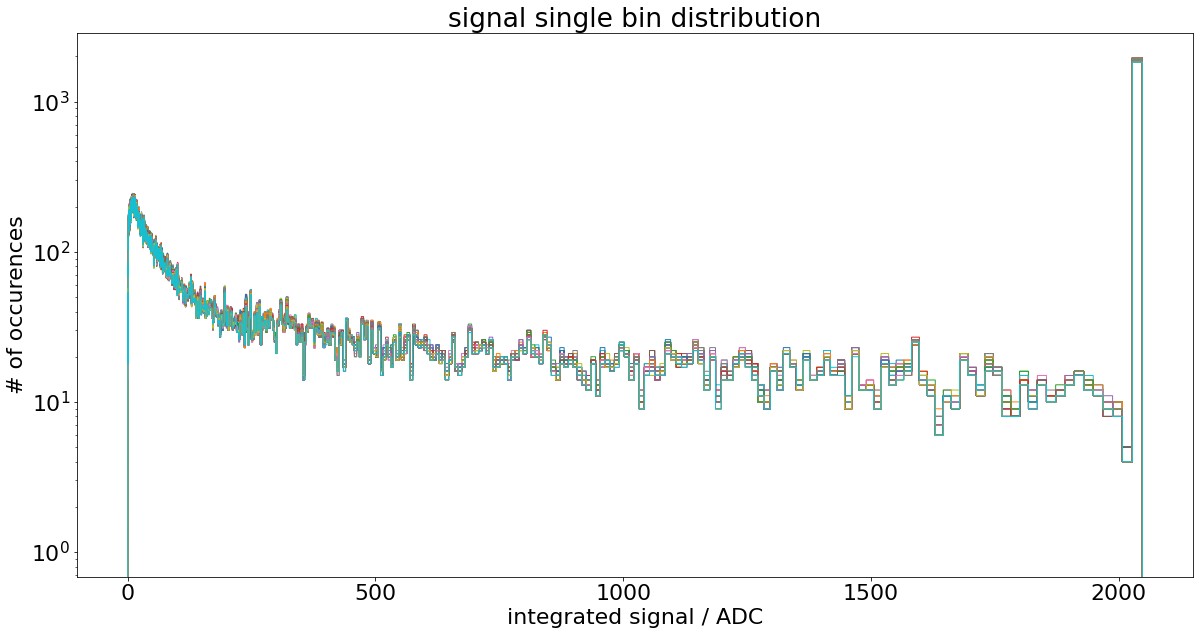

In [8]:
plt.title("signal single bin distribution")
bin_edges = np.geomspace(1e-1, 2048, 1001)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
signal_bin_pdfs = []

for bin in bin_distributions_signal:
    n, bins, patches = plt.hist(bin, histtype = "step", bins = bin_edges)
    bin_pdfs.append(n / n.sum())

plt.xlabel("integrated signal / ADC")
plt.ylabel("# of occurences")
plt.yscale("log")

signal_bin_pdf = np.mean(np.array(bin_pdfs), axis = 0)
signal_bin_pdf /= signal_bin_pdf.sum()

1.0


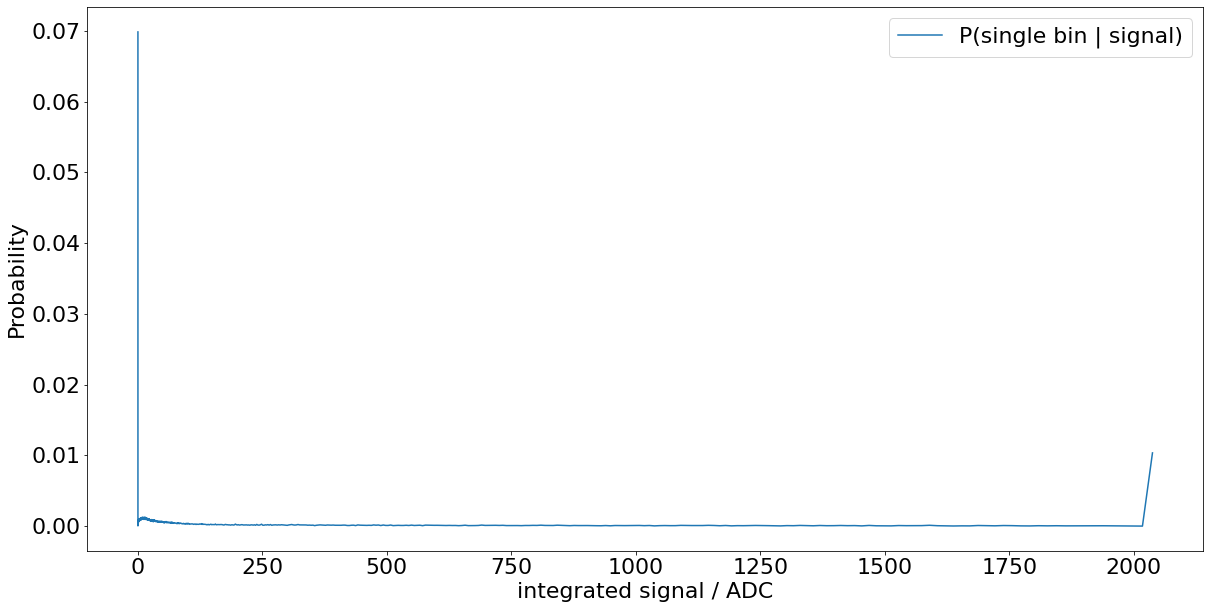

In [9]:
plt.plot(bin_centers, signal_bin_pdf, label = "P(single bin | signal)")
print(signal_bin_pdf.sum())

plt.ylabel("Probability")
plt.xlabel("integrated signal / ADC")
plt.legend()

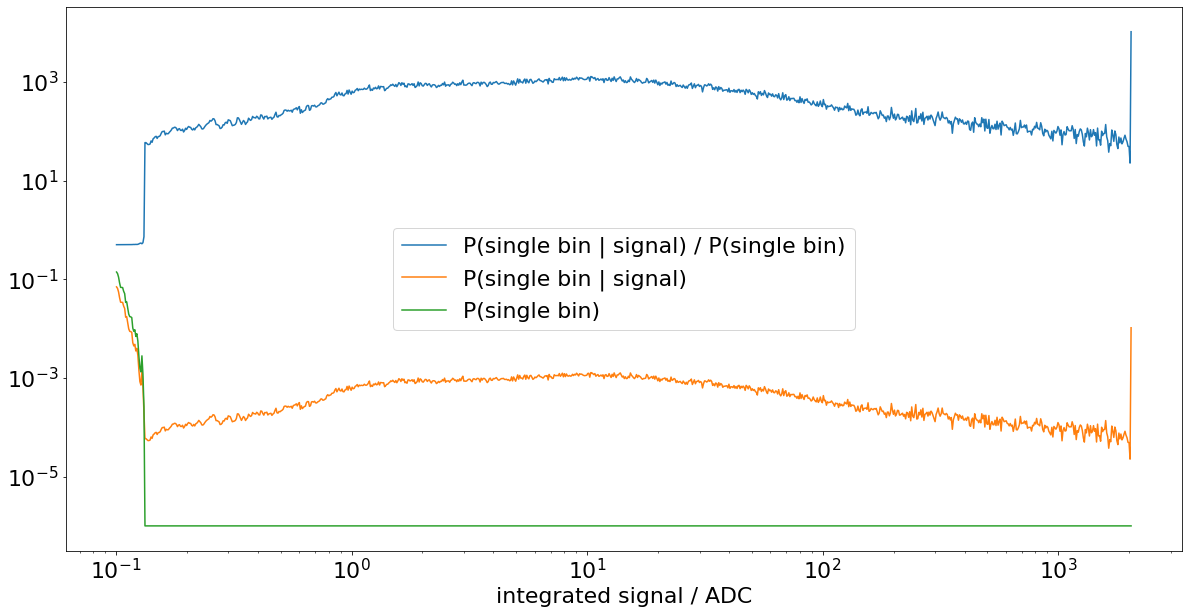

In [10]:
all_bin_pdf = np.clip(np.array(all_bin_pdf), 1e-6, 2048)
quotient = (signal_bin_pdf / all_bin_pdf)

plt.plot(bin_centers, quotient, label = "P(single bin | signal) / P(single bin)")
plt.plot(bin_centers, signal_bin_pdf, label = "P(single bin | signal)")
plt.plot(bin_centers, all_bin_pdf, label = "P(single bin)")
plt.xlabel("integrated signal / ADC")
plt.yscale("log")
plt.xscale("log")
plt.legend()

In [11]:
with open("/cr/data01/filip/models/naive_bayes_classifier/bins.csv", "w") as bins:
    for bin in bin_centers: bins.write(str(bin) + " ")

with open("/cr/data01/filip/models/naive_bayes_classifier/signal.csv", "w") as signal:
    for bin in signal_bin_pdf: signal.write(str(bin) + " ")

with open("/cr/data01/filip/models/naive_bayes_classifier/background.csv", "w") as background:
    for bin in all_bin_pdf: background.write(str(bin) + " ")

Let's try and make some predictions with it

In [12]:
from TriggerStudyBinaries_v5 import *

AllSignalEvents = EventGenerator(["16_16.5"], real_background = True, prior = 0.5, force_inject = 0, split = 1, step = 1)
Test = BayesianClassifier()

traces, labels = AllSignalEvents.__getitem__(0, full_trace = True)
trace = traces[0]


ModuleNotFoundError: No module named 'TriggerStudyBinaries_v5'

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

trace.__plot__()
x, y = [], []

for bin in AllSignalEvents.__sliding_window__(trace, override_prior = True):


    window, n_sig = trace.get_trace_window((bin, bin + AllSignalEvents.window_length))

    x.append(bin), y.append(Test(window))

plt.figure()
plt.xlim(0,2048)
plt.plot(x,y)
plt.xlabel("Bin / 8.3 ns")
plt.ylabel("mock likelihood")